In [10]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from copy import deepcopy

In [2]:
def parser(file_name):
    with open(file_name) as f:
        data = f.readlines()
    boxes = {}
    for i in range(len(data)):
        line = data[i].split('\t')
        pos = list(map(int, line[0].split(',')))
        size = list(map(int, line[1].split(',')))
        locations = []
        for loc in line[2].split(' '):
            locations.append(list(map(int, loc.split(','))))
        boxes[str(i)] = {'pos' : pos, 'size': size, 'locations' : locations}
    return boxes

In [3]:
# смотрим, не вылезают ли прямоугольники за границу 500*500
# если нет, то смещение заменяем нижним левым углом прямоугольника
def validation(boxes):
    boxes_new = {}
    for k, v in boxes.items():
        locations_new = []
        for loc in v['locations']:
            x_new = v['pos'][0] - loc[0]
            y_new = v['pos'][1] - loc[1]
            if (x_new + v['size'][0] <= 500) and (x_new >= 0) and (y_new + v['size'][1] <= 500) and (y_new >= 0):
                locations_new.append([x_new, y_new])
        if len(locations_new) == 1:
            locations_new += locations_new
        if len(locations_new) == 0:
            return None
        else:
            boxes_new[k] = {'pos' : v['pos'], 'size': v['size'], 'locations' : locations_new}
    return boxes_new

In [4]:
# факт пересечения двух прямоугольников
def cross(rec1, rec2, size1, size2):
    if (rec1[0] > rec2[0] + size2[0] or rec2[0] > rec1[0] + size1[0]):
        return False
    if (rec1[1] > rec2[1] + size2[1] or rec2[1] > rec1[1] + size1[1]):
        return False
    return True
            

In [5]:
# строим граф с имликациями
def get_graph(boxes):
    graph = {}
    for k1, box1 in boxes.items():
        graph[k1] = []
        graph['x' + k1] = []
        for k2, box2 in boxes.items():
            if k1 != k2:
                for i in range(len(box1['locations'])):
                    for j in range(len(box2['locations'])):
                        if cross(box1['locations'][i], box2['locations'][j], box1['size'], box2['size']):
                            if (i == 0) and (j == 0):
                                graph['x' + k1].append(k2)
                            elif (i == 0) and (j == 1):
                                graph['x' + k1].append('x' + k2)
                            elif (i == 1) and (j == 0):
                                graph[k1].append(k2)
                            elif (i == 1) and (j == 1):
                                graph[k1].append('x' + k2)
    return graph

In [6]:
def dfs(ver):
    visited[ver] = True
    order.append(ver)
    for u in graph[ver]:
        if not visited[u]:
            dfs(u)
def dfs_rev(ver, col):
    comp[ver] = col
    for u in tgraph[ver]:
        if comp[u] == -1:
            dfs_rev(u, col)

### здесь считывается файл

In [7]:
boxes_ = parser('bin1.txt')
boxes = validation(boxes_)

In [8]:
if boxes is None:
        print('Расположение недостижимо')
else:
    graph = get_graph(boxes)
    tgraph = {}
    for k in graph:
        tgraph[k] = []
    for k, val in graph.items():
        for v in val:
            tgraph[v].append(k)
    visited = {}
    for k in graph:
        visited[k] = False
    order = []
    comp = {}
    for k in graph:
        comp[k] = -1
        
    for k in graph.keys():
        if not visited[k]:
            dfs(k)
    col = 0
    for i in range(len(graph)):
        ver = order[len(graph) - i - 1]
        if comp[ver] == -1:
            dfs_rev(ver, col)
            col += 1
    real_flag = 1
    for k in boxes:
        if comp[k] == comp['x' + k]:
            print('Расположение недостижимо')
            real_flag = 0
            break

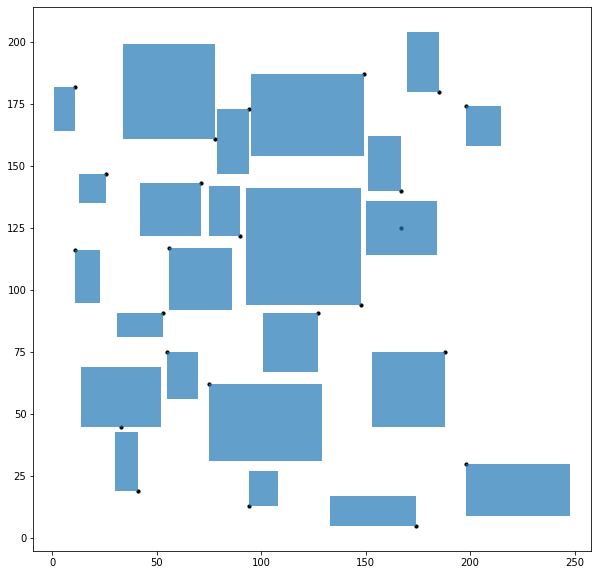

In [9]:
if real_flag:
    right_positions = deepcopy(boxes)
    for k in right_positions:
        if comp[k] >= comp['x' + k]:
            right_positions[k]['locations'] = boxes[k]['locations'][1]
        else:
            right_positions[k]['locations'] = boxes[k]['locations'][0]

    max_x = 0
    max_y = 0
    min_y = 500
    min_x = 500
    for k, v in right_positions.items():
        if v['locations'][0] < min_x:
            min_x = v['locations'][0]
        if v['locations'][1] < min_y:
            min_y = v['locations'][1]
        if v['locations'][0] + v['size'][0] > max_x:
            max_x = v['locations'][0] + v['size'][0]
        if v['locations'][1] + v['size'][1] > max_y:
            max_y = v['locations'][1] + v['size'][1]

    fig, ax = plt.subplots(figsize=(10, 10))
    xpoints = []
    ypoints = []
    for k, val in right_positions.items():
        rect = patches.Rectangle(tuple(val['locations']), val['size'][0], val['size'][1],alpha=0.7)
        ax.add_patch(rect)
        xpoints.append(val['pos'][0])
        ypoints.append(val['pos'][1])
    ax.scatter(xpoints, ypoints, color='black', s=10)
    plt.xlim(min_x-10, max_x+10)
    plt.ylim(min_y-10, max_y+10)
    plt.show()
else:
    print('Расположение недостижимо')